In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

data = pd.read_csv('db_online.csv', parse_dates=["InvoiceDate"], date_format='%Y-%m-%d %H:%M:%S')


print(data.shape)
data.head()

(1048575, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom


In [2]:
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as cluster_model


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  float64
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 64.0+ MB


In [4]:
data.describe()

,Quantity,Price,Customer ID
count,1.048575e+06,1.048575e+06,811893.000000
mean,9.957525e+00,4.627346e+00,15324.712265
std,1.335187e+02,1.228024e+02,1697.033034
min,-7.421500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13971.000000
50%,3.000000e+00,2.100000e+00,15260.000000
75%,1.000000e+01,4.150000e+00,16795.000000
max,7.421500e+04,3.897000e+04,18287.000000


In [5]:
df_null = round(100*(data.isnull().sum())/len(data), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.42
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.57
Country         0.00
dtype: float64

In [6]:
# Droping rows having missing values

data = data.dropna()
data.shape

(811893, 8)

In [7]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom


In [8]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 811893 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      811893 non-null  object 
 1   StockCode    811893 non-null  object 
 2   Description  811893 non-null  object 
 3   Quantity     811893 non-null  int64  
 4   InvoiceDate  811893 non-null  object 
 5   Price        811893 non-null  float64
 6   Customer ID  811893 non-null  float64
 7   Country      811893 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 295.1 MB


In [9]:
print(f"Number of unique transactions: {data['Invoice'].nunique()}")

Number of unique transactions: 44278


A random check showed that there are inaccuracies in the data - the first character is not always equal to "C", but can also be equal to "A". There are few such errors, but if this were a real business task, we would need to find out from the business customer the reason for such errors. Let's create a column that will indicate whether the order was canceled or not

In [10]:
data["first_letter"] = data['Invoice'].apply(lambda x: "" if x[0].isdigit() else x[0])
data["first_letter"].value_counts()

first_letter
     793380
C     18513
Name: count, dtype: int64

In [11]:
data.drop_duplicates(subset="Invoice")["first_letter"].value_counts()

first_letter
     36463
C     7815
Name: count, dtype: int64

In [12]:
data['cancellation'] = data['Invoice'].apply(lambda x: 1 if x[0]=='C' else 0)

In [13]:
display(data[data["first_letter"]=="C"])
display(data[data["Price"]>100])

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,first_letter,cancellation
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,12/1/09 10:33,2.95,16321.0,Australia,C,1
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,12/1/09 10:33,1.65,16321.0,Australia,C,1
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,12/1/09 10:33,4.25,16321.0,Australia,C,1
181,C489449,21896,POTTING SHED TWINE,-6,12/1/09 10:33,2.10,16321.0,Australia,C,1
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,12/1/09 10:33,2.95,16321.0,Australia,C,1
...,...,...,...,...,...,...,...,...,...,...
1046566,C580313,22649,STRAWBERRY FAIRY CAKE TEAPOT,-3,12/2/11 15:10,4.95,12668.0,Germany,C,1
1046567,C580313,22419,LIPSTICK PEN RED,-6,12/2/11 15:10,0.42,12668.0,Germany,C,1
1046568,C580313,22303,COFFEE MUG APPLES DESIGN,-2,12/2/11 15:10,2.55,12668.0,Germany,C,1
1046569,C580313,21232,STRAWBERRY CERAMIC TRINKET POT,-3,12/2/11 15:10,1.25,12668.0,Germany,C,1


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,first_letter,cancellation
126,489444,POST,POSTAGE,1,12/1/09 9:55,141.00,12636.0,USA,,0
173,489447,POST,POSTAGE,1,12/1/09 10:10,130.00,12362.0,Belgium,,0
9307,C490129,M,Manual,-1,12/3/09 18:26,1998.49,15482.0,United Kingdom,C,1
17273,C490748,M,Manual,-1,12/7/09 18:14,309.73,12748.0,United Kingdom,C,1
21450,491094,POST,POSTAGE,1,12/9/09 13:49,216.00,12709.0,Germany,,0
...,...,...,...,...,...,...,...,...,...,...
1011035,577609,POST,POSTAGE,1,11/21/11 9:51,300.00,12349.0,Italy,,0
1020188,578270,DOT,DOTCOM POSTAGE,1,11/23/11 13:39,1270.06,14096.0,United Kingdom,,0
1020205,C578269,CRUK,CRUK Commission,-1,11/23/11 13:39,849.93,14096.0,United Kingdom,C,1
1033920,579196,DOT,DOTCOM POSTAGE,1,11/28/11 15:54,1526.76,14096.0,United Kingdom,,0


In [14]:
# utilizing SQL
import pandasql as ps

query = "SELECT * FROM data WHERE Price >100"

result = ps.sqldf(query, locals())

result

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,first_letter,cancellation
0,489444,POST,POSTAGE,1,12/1/09 9:55,141.00,12636.0,USA,,0
1,489447,POST,POSTAGE,1,12/1/09 10:10,130.00,12362.0,Belgium,,0
2,C490129,M,Manual,-1,12/3/09 18:26,1998.49,15482.0,United Kingdom,C,1
3,C490748,M,Manual,-1,12/7/09 18:14,309.73,12748.0,United Kingdom,C,1
4,491094,POST,POSTAGE,1,12/9/09 13:49,216.00,12709.0,Germany,,0
...,...,...,...,...,...,...,...,...,...,...
625,577609,POST,POSTAGE,1,11/21/11 9:51,300.00,12349.0,Italy,,0
626,578270,DOT,DOTCOM POSTAGE,1,11/23/11 13:39,1270.06,14096.0,United Kingdom,,0
627,C578269,CRUK,CRUK Commission,-1,11/23/11 13:39,849.93,14096.0,United Kingdom,C,1
628,579196,DOT,DOTCOM POSTAGE,1,11/28/11 15:54,1526.76,14096.0,United Kingdom,,0


In [15]:
data['test__Invoice_int'] = data['Invoice'].apply(lambda x: int(x) if x[0] not in ('C', 'A') else int(x[1:]))

In [16]:
data['test__Invoice_int'] = data['Invoice'].apply(lambda x: int(x) if x[0] not in ('C', 'A') else int(x[1:]))

In [17]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Calculate the date difference using pandasql
query = """
    SELECT 
        Invoice,
        MAX(InvoiceDate) - MIN(InvoiceDate) AS DateDifference
    FROM 
        data
    GROUP BY 
        Invoice
"""

result = ps.sqldf(query, locals())
print(result)

/var/folders/f1/f4pv93hj5mzbv8wfv_s18dr80000gn/T/ipykernel_28407/2161036128.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


       Invoice  DateDifference
0       489434               0
1       489435               0
2       489436               0
3       489437               0
4       489438               0
...        ...             ...
44273  C580180               0
44274  C580263               0
44275  C580312               0
44276  C580313               0
44277  C580392               0

[44278 rows x 2 columns]


In [19]:
data.drop_duplicates(subset="Invoice").iloc[55:60]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,first_letter,cancellation,test__Invoice_int
1000,489546,84050,PINK HEART SHAPE EGG FRYING PAN,6,2009-12-01 12:30:00,1.65,14156.0,EIRE,,0,489546
1014,489547,22086,PAPER CHAIN KIT 50'S CHRISTMAS,18,2009-12-01 12:30:00,2.95,13599.0,United Kingdom,,0,489547
1110,C489549,35400,WOODEN BOX ADVENT CALENDAR,-2,2009-12-01 12:33:00,7.95,13768.0,United Kingdom,C,1,489549
1111,489550,48187,DOOR MAT NEW ENGLAND,2,2009-12-01 12:33:00,6.75,14156.0,EIRE,,0,489550
1134,C489551,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 12:35:00,6.95,17641.0,United Kingdom,C,1,489551


In [20]:
data.drop_duplicates(subset="Invoice")["test__Invoice_int"].diff().iloc[55:60]

1000    1.0
1014    1.0
1110    2.0
1111    1.0
1134    1.0
Name: test__Invoice_int, dtype: float64

In [21]:
invoiceno_uniqdf = data.drop_duplicates(subset="Invoice")

In [22]:
invoiceno_uniqdf["test__Invoice_int_diff"] = invoiceno_uniqdf["test__Invoice_int"].diff()
invoiceno_uniqdf["InvoiceDate_day"] = invoiceno_uniqdf["InvoiceDate"].dt.date
invoiceno_uniqdf.head(3)

/var/folders/f1/f4pv93hj5mzbv8wfv_s18dr80000gn/T/ipykernel_28407/2731004112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoiceno_uniqdf["test__Invoice_int_diff"] = invoiceno_uniqdf["test__Invoice_int"].diff()
/var/folders/f1/f4pv93hj5mzbv8wfv_s18dr80000gn/T/ipykernel_28407/2731004112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invoiceno_uniqdf["InvoiceDate_day"] = invoiceno_uniqdf["InvoiceDate"].dt.date


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,first_letter,cancellation,test__Invoice_int,test__Invoice_int_diff,InvoiceDate_day
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,,0,489434,NaN,2009-12-01
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,,0,489435,1.0,2009-12-01
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,,0,489436,1.0,2009-12-01


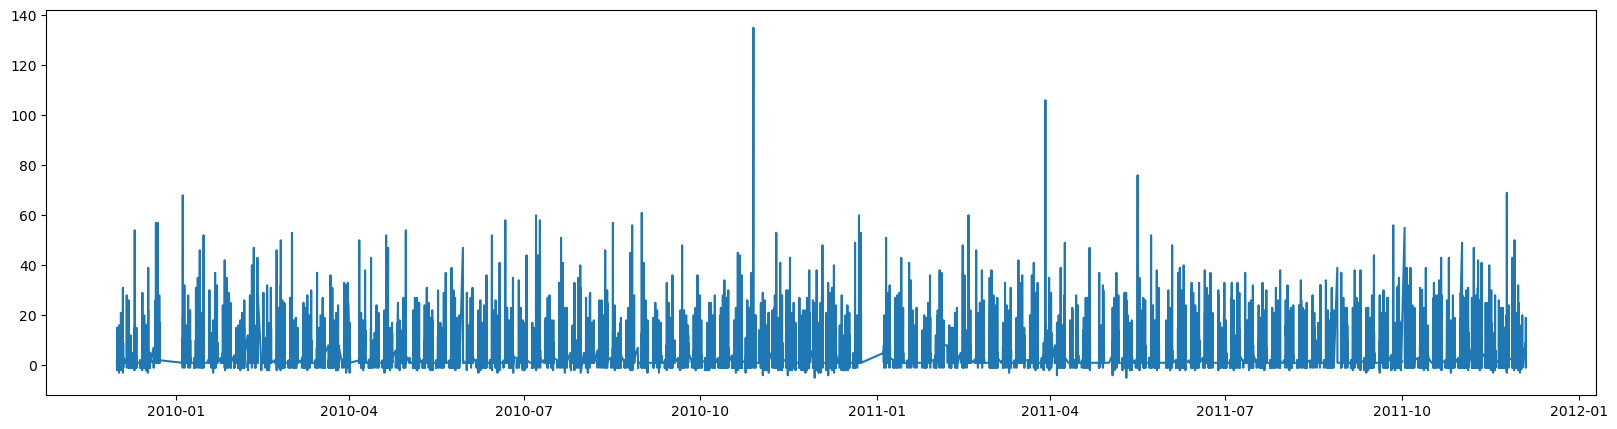

In [23]:
invoiceno_uniqdf[["InvoiceDate", "test__Invoice_int_diff"]]
plt.figure(figsize=(20, 5))
plt.plot(invoiceno_uniqdf["InvoiceDate"], invoiceno_uniqdf["test__Invoice_int_diff"]);

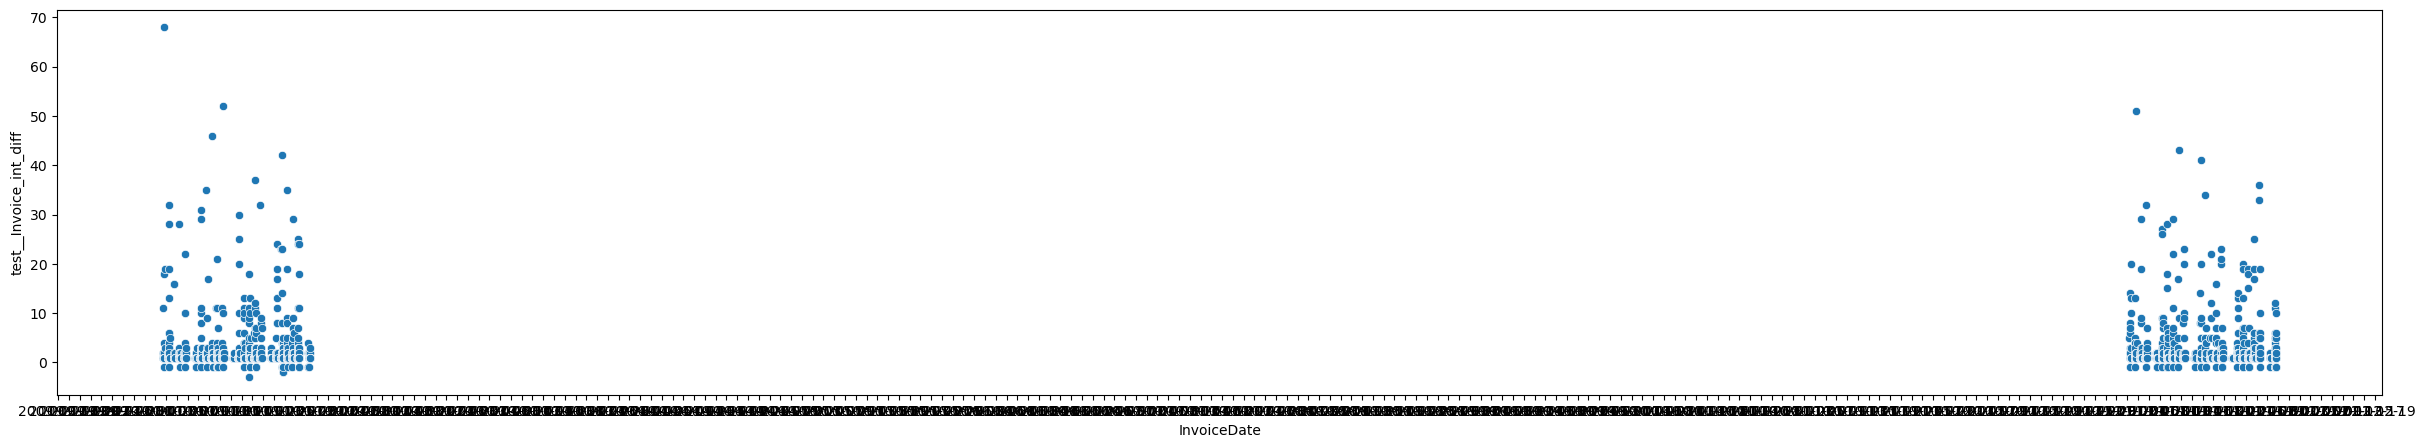

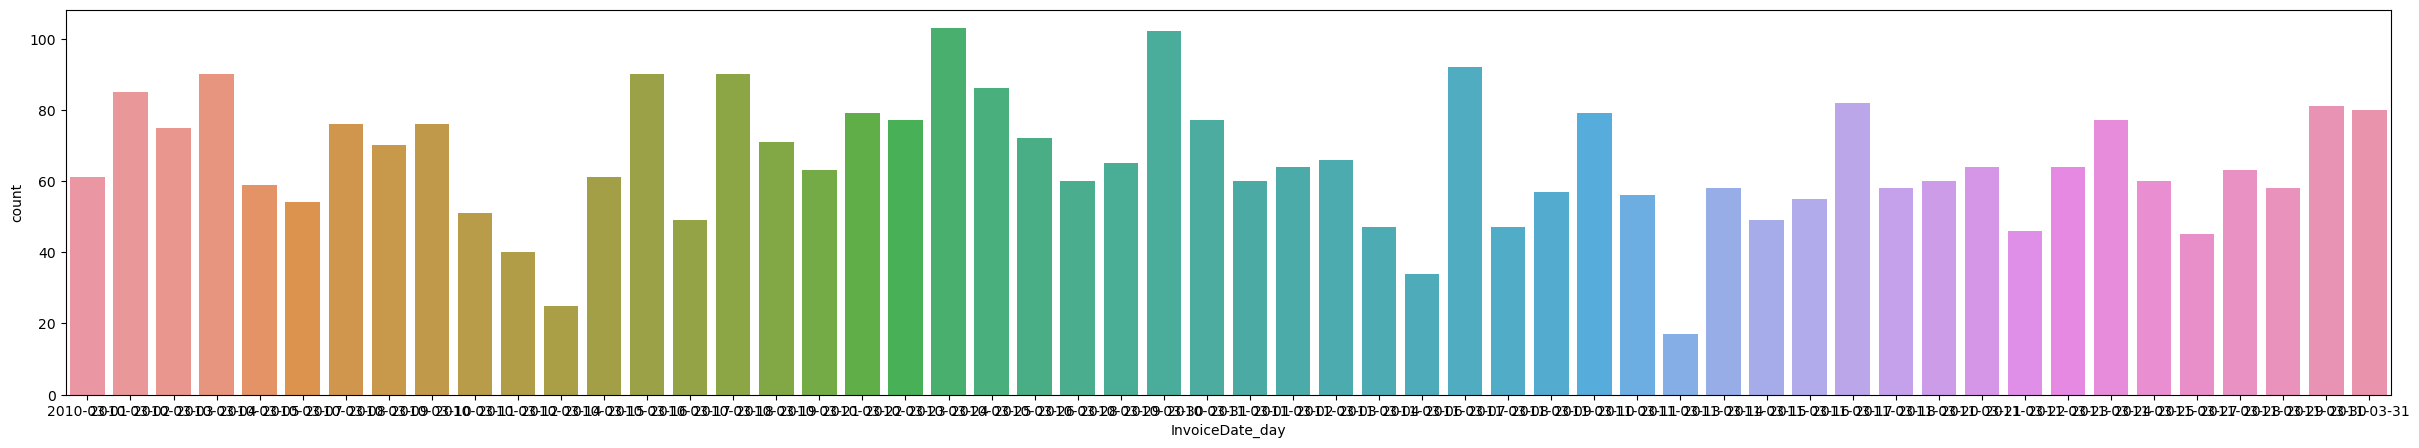

In [24]:
plt.figure(figsize=(30, 5))
g = sns.scatterplot(
    x = "InvoiceDate",
    y = "test__Invoice_int_diff",
    data=invoiceno_uniqdf[invoiceno_uniqdf["InvoiceDate"].dt.month==1]
)
g.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

plt.figure(figsize=(30, 5))
g1 = sns.countplot(
    x = "InvoiceDate_day",
    data=invoiceno_uniqdf[invoiceno_uniqdf["InvoiceDate"].dt.month==3]
)
g1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

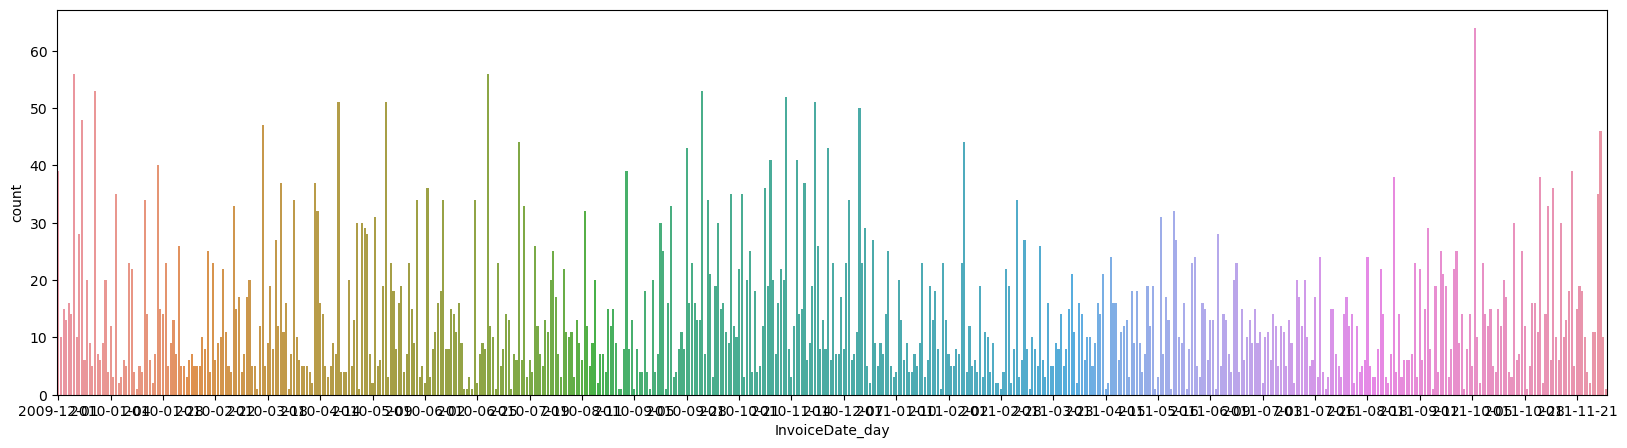

In [25]:
filter_expr = (invoiceno_uniqdf["cancellation"]==1)

plt.figure(figsize=(20, 5))
g = sns.countplot(
    x = "InvoiceDate_day",
    data=invoiceno_uniqdf[filter_expr]
)
g.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

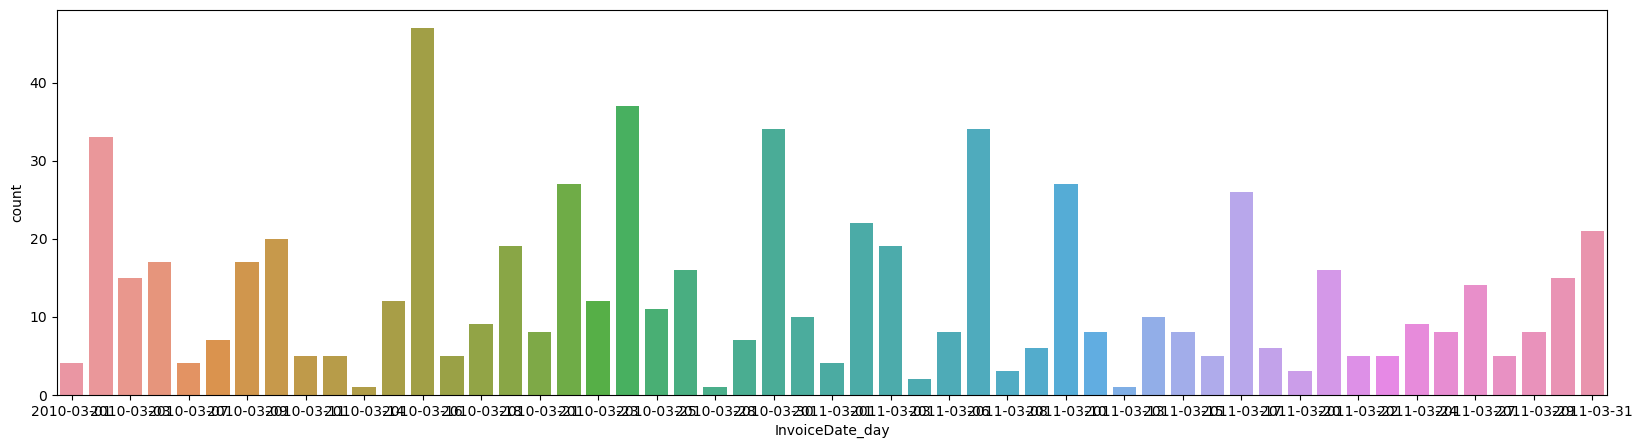

In [26]:
filter_expr = (invoiceno_uniqdf["InvoiceDate"].dt.month==3) & (invoiceno_uniqdf["cancellation"]==1)
plt.figure(figsize=(20, 5))
g = sns.countplot(
    x = "InvoiceDate_day",
    data=invoiceno_uniqdf[filter_expr]
)
g.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.show()

In [27]:
data = data.drop(["test__Invoice_int", "first_letter"], axis=1)

/Users/lisako/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


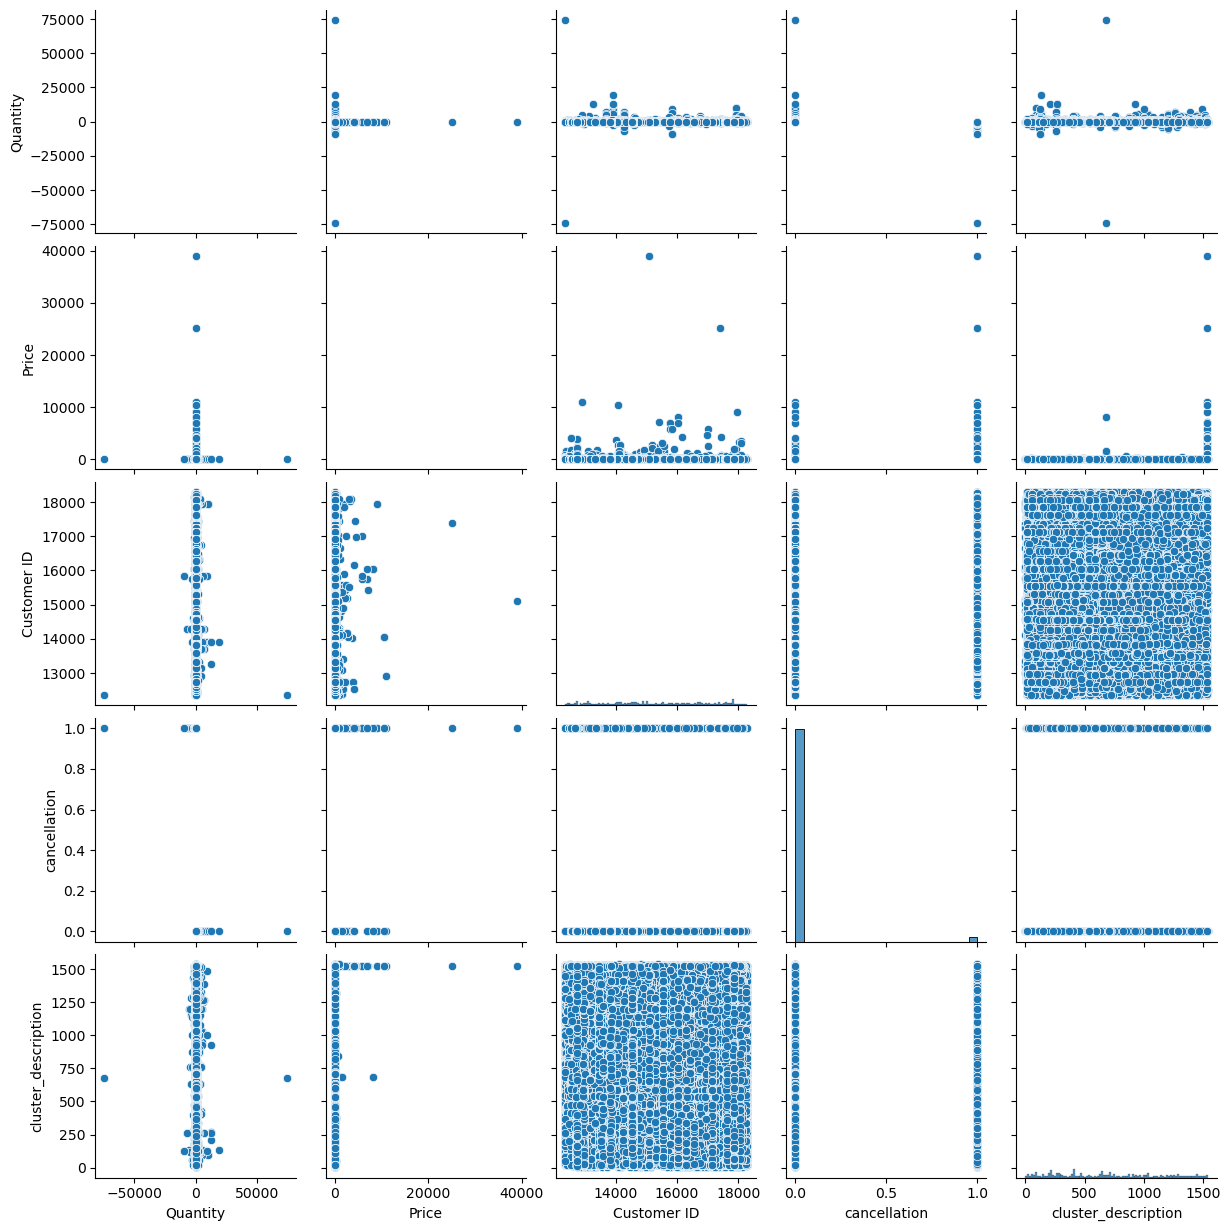

In [51]:
sns.pairplot(data=data)
plt.show()

## StockCode, Description, Quantity
In this block, we will consider the offered goods and their description. Let's look at various statistics on them, try to understand what goods we are dealing with. Thus, we will already estimate what features we can build for our future model. We will also try to cluster products into typical groups, if possible. If we build features by coarse categories, this may work better for some models.

In [28]:
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancellation
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0


In [29]:
data["StockCode"].nunique(), data["Description"].nunique()

(4645, 5297)

In [30]:
unique_descr = sorted(data["Description"].dropna().unique(), key=len)
print(unique_descr[:150])

['Manual', 'POSTAGE', 'Discount', 'CARRIAGE', 'CAT BOWL ', 'BINGO SET', 'SPACE OWL', 'SOMBRERO ', 'SPOTS MUG', 'PHOTO CUBE', 'SPACE FROG', 'DAISY RING', 'SKULLS WRAP', 'FROG CANDLE', 'SKULLS TAPE', 'CONCH SHELL', 'BUTTON BOX ', 'CORDIAL JUG', 'LIBRARY LAMP', 'DOGGY RUBBER', 'MOON INCENSE', 'OWL DOORSTOP', 'RAIN PONCHO ', 'GOLD WASHBAG', 'EMPIRE TEDDY', 'Bank Charges', 'WICKER STAR ', 'POLKADOT PEN', 'CHAMBRE HOOK', 'POTTERING MUG', 'WRAP BLIZZARD', 'FIRST AID TIN', 'PARTY BUNTING', 'CHILLI LIGHTS', 'WRAP FOLK ART', 'BUNNY EGG BOX', 'WRAP BOUDOIR ', ' Bank Charges', 'PINK FLY SWAT', 'ORANGE CANDLE', 'TOYBOX  WRAP ', 'BLUE FLY SWAT', 'PINK DOG BOWL', 'PINK CAT BOWL', 'POLKA DOT PEN', 'POLKADOT PENS', 'WRAP CAROUSEL', 'BATHROOM HOOK', 'LOCAL CAFE MUG', 'DOORMAT HEARTS', 'RED SPOTTY CUP', 'RETRO SPOT MUG', 'JUMBO BAG OWLS', 'KEY FOB , SHED', 'CUTE CATS TAPE', 'SILVER WASHBAG', 'GLAMOROUS  MUG', 'SANDALWOOD FAN', 'RIBBONS PURSE ', 'POMPOM CURTAIN', 'DAISY JOURNAL ', 'POSY CANDY BAG', 'RETRO

In [31]:
data[
    data["Description"].isin(unique_descr[:15])
]["Price"].describe()

count     5119.000000
mean       111.779074
std        880.782807
min          0.000000
25%          1.950000
50%         15.000000
75%         18.000000
max      38970.000000
Name: Price, dtype: float64

In [32]:
# selectively looking at examples with weird description

data[data["cancellation"]==1].sample(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cancellation
708028,C552556,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,-24,2011-05-10 11:21:00,0.85,17504.0,United Kingdom,1
172597,C505727,21775,DECORATIVE FLORE BATHROOM BOTTLE,-1,2010-04-25 14:06:00,1.25,16984.0,United Kingdom,1
981323,C575650,22726,ALARM CLOCK BAKELIKE GREEN,-1,2011-11-10 14:24:00,3.75,14194.0,United Kingdom,1
159143,C504570,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-1,2010-04-14 14:23:00,4.25,17511.0,United Kingdom,1
188911,C507358,79323W,WHITE CHERRY LIGHTS,-3,2010-05-07 15:30:00,6.75,14527.0,United Kingdom,1


In [33]:
data[data["cancellation"]==1]["Quantity"].describe()

count    18513.000000
mean       -21.810728
std        573.014221
min     -74215.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64

In [34]:
data = data.drop(data[(data["Price"]==0) &
     (data["Description"].isnull()) & 
     (data["Customer ID"].isnull())
    ].index)
print(data.shape)

(811893, 9)


In [35]:
data[(data["cancellation"]!=1) & (data["Quantity"]<0)]["Customer ID"].value_counts()

Series([], Name: count, dtype: int64)

In [36]:
data[(data["cancellation"]!=1) & (data["Quantity"]<0)]["Description"].value_counts().head(10)

Series([], Name: count, dtype: int64)

In [37]:
data = data.drop(data[(data["cancellation"]!=1) & (data["Quantity"]<0)].index)
print(data.shape)

(811893, 9)


In [38]:
data[(data["cancellation"]!=1)]["Quantity"].describe()

count    793380.000000
mean         13.221014
std         113.376231
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       74215.000000
Name: Quantity, dtype: float64

In [39]:
print(sorted(data["Description"].dropna().unique(), key=len)[:100])

['Manual', 'POSTAGE', 'Discount', 'CARRIAGE', 'CAT BOWL ', 'BINGO SET', 'SPACE OWL', 'SOMBRERO ', 'SPOTS MUG', 'PHOTO CUBE', 'SPACE FROG', 'DAISY RING', 'SKULLS WRAP', 'FROG CANDLE', 'SKULLS TAPE', 'CONCH SHELL', 'BUTTON BOX ', 'CORDIAL JUG', 'LIBRARY LAMP', 'DOGGY RUBBER', 'MOON INCENSE', 'OWL DOORSTOP', 'RAIN PONCHO ', 'GOLD WASHBAG', 'EMPIRE TEDDY', 'Bank Charges', 'WICKER STAR ', 'POLKADOT PEN', 'CHAMBRE HOOK', 'POTTERING MUG', 'WRAP BLIZZARD', 'FIRST AID TIN', 'PARTY BUNTING', 'CHILLI LIGHTS', 'WRAP FOLK ART', 'BUNNY EGG BOX', 'WRAP BOUDOIR ', ' Bank Charges', 'PINK FLY SWAT', 'ORANGE CANDLE', 'TOYBOX  WRAP ', 'BLUE FLY SWAT', 'PINK DOG BOWL', 'PINK CAT BOWL', 'POLKA DOT PEN', 'POLKADOT PENS', 'WRAP CAROUSEL', 'BATHROOM HOOK', 'LOCAL CAFE MUG', 'DOORMAT HEARTS', 'RED SPOTTY CUP', 'RETRO SPOT MUG', 'JUMBO BAG OWLS', 'KEY FOB , SHED', 'CUTE CATS TAPE', 'SILVER WASHBAG', 'GLAMOROUS  MUG', 'SANDALWOOD FAN', 'RIBBONS PURSE ', 'POMPOM CURTAIN', 'DAISY JOURNAL ', 'POSY CANDY BAG', 'RETRO

# Description similarity

finding similar description names using a bag of words

In [40]:
uniq_descr = data["Description"].unique()
uniq_descr

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., 'GIN AND TONIC DIET METAL SIGN',
       'SET OF 6 RIBBONS PARTY', 'SILVER AND BLACK ORBIT NECKLACE'],
      dtype=object)

In [41]:
# bag of words
single_symbols = [
    '', 'u','a','y','g','j','k','v','w','z','c','h',
    'r','f','p','o','m','t','l','b','i','e','s','d','x','n',
    'if', 'it', 'to', 'or', 'of', 'is', 'and', 'with'
                 ]
i = 0
uniq_words = []
uniq_descr_ = []
for descr in uniq_descr:
    descr_ = re.split('[^a-z]', descr.lower().strip())
    descr_ = [i for i in descr_ if i not in single_symbols]
    uniq_descr_.append(descr_)
    for word in descr_:
        uniq_words.append(word)
uniq_words = set(uniq_words)

# create zeros dataframe
full_vectorize = pd.DataFrame(
    np.zeros(shape=(len(uniq_descr_), len(uniq_words)))
)
full_vectorize.columns = uniq_words
full_vectorize.index = uniq_descr

# make correct vectors
for ind_desr, descr in tqdm(enumerate(uniq_descr_)):
    for word in descr:
        full_vectorize[word][ind_desr] = 1

5297it [00:30, 172.96it/s]


In [42]:
full_vectorize.head()

,puppies,robin,cmx,beads,magnet,salle,digestive,adjustment,scandinavian,treasure,...,fields,whit,chair,dome,french,slice,necklac,memory,organdy,vanity
15CM CHRISTMAS GLASS BALL 20 LIGHTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PINK CHERRY LIGHTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WHITE CHERRY LIGHTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"RECORD FRAME 7"" SINGLE SIZE",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
STRAWBERRY CERAMIC TRINKET BOX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


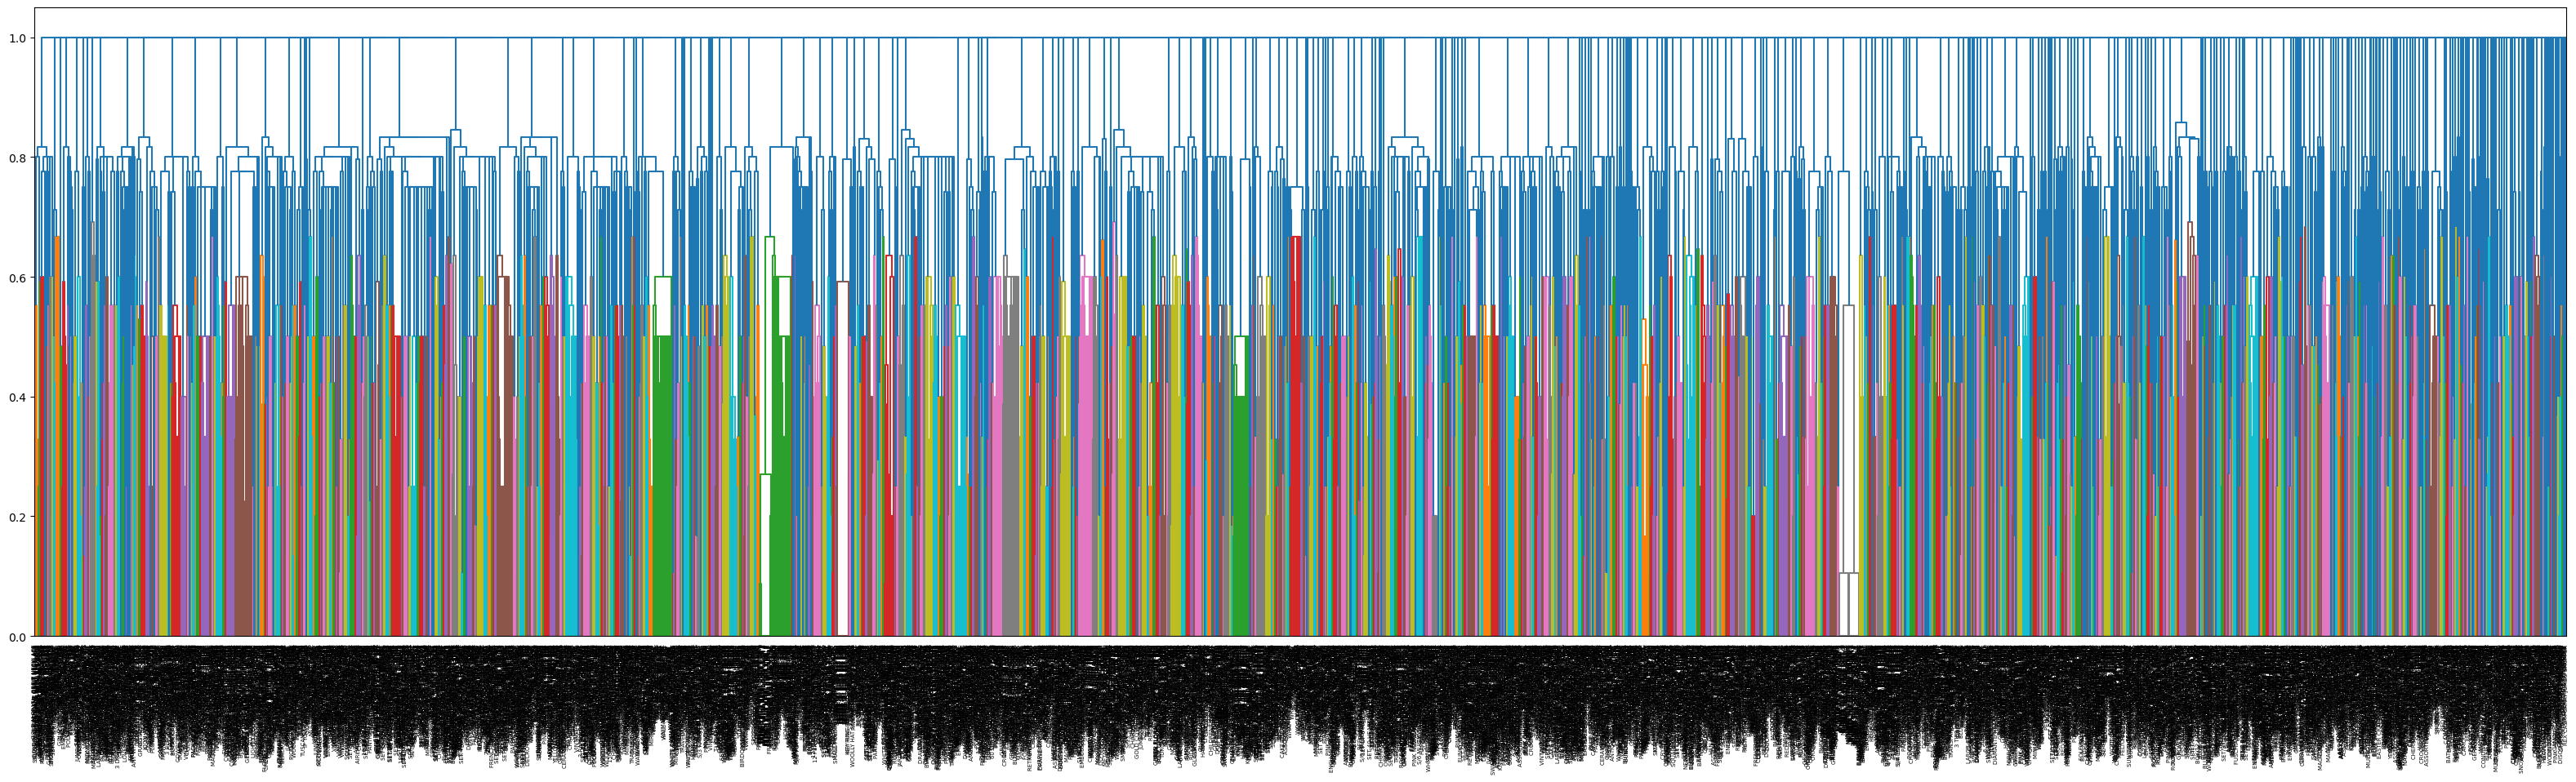

In [43]:
plt.figure(figsize=(40, 10))

# fit hierarchical clustering from scipy
result_model = cluster_model.linkage(full_vectorize[:], method='complete', metric="cosine")
dend_cos = cluster_model.dendrogram(result_model, labels=full_vectorize.index[:])

In [44]:
# choose threshold from plot
t = 0.9
cluster_labels = fcluster(result_model, t,  criterion="inconsistent")

In [45]:
# comparison original and cluster shapes
print(full_vectorize.shape[0], len(set(cluster_labels)))

5297 1537


In [46]:
cluster_dict = {
    i:j for i,j in zip(full_vectorize.index.tolist(), cluster_labels.tolist())
}
data["cluster_description"] = data["Description"].apply(lambda x: cluster_dict[x])

In [47]:
# example of cluster 1
data[["Description", "cluster_description"]].sort_values(by="cluster_description").head()

,Description,cluster_description
340209,GOLD/M.O.P PENDANT ORBIT NECKLACE,1
174762,GOLD/M.O.P PENDANT ORBIT NECKLACE,1
912110,GOLD M.O.P. ORBIT NECKLACE,1
933144,GOLD/M.O.P PENDANT ORBIT NECKLACE,1
249058,GOLD/M.O.P PENDANT ORBIT NECKLACE,1


In [48]:
# countries could also be clustered, but nothing to do with bag of words

print(data["Country"].nunique())
data["Country"].value_counts().head(10)

41


Country
United Kingdom    730115
Germany            17327
EIRE               15910
France             13972
Netherlands         5054
Spain               3740
Switzerland         3064
Belgium             3056
Portugal            2450
Australia           1913
Name: count, dtype: int64

In [49]:
piv_data = data[["Country", "cancellation"]].groupby("Country").agg({"cancellation": [sum, 'count']})
piv_data["cancellation", "perc"] = piv_data["cancellation"]["sum"] / piv_data["cancellation"]["count"]

In [50]:
piv_data.sort_values(by=[("cancellation", "perc")], ascending=False)

cancellation                  
                              sum   count      perc
Country                                            
USA                           115     503  0.228628
Czech Republic                  5      30  0.166667
Korea                          10      63  0.158730
Japan                          89     574  0.155052
Saudi Arabia                    1      10  0.100000
Malta                          17     299  0.056856
Channel Islands                94    1658  0.056695
Germany                       903   17327  0.052115
Australia                      98    1913  0.051228
Italy                          66    1526  0.043250
Poland                         23     535  0.042991
EIRE                          450   15910  0.028284
France                        386   13972  0.027627
Denmark                        19     806  0.023573
Portugal                       57    2450  0.023265
Spain                          85    3740  0.022727
United Kingdom              15824  730115  0.021673
Singapore                       7     346  0.020231
Sweden                         25    1343  0.018615
Cyprus                         21    1176  0.017857
Belgium                        54    3056  0.017670
Austria                        16     931  0.017186
Switzerland                    52    3064  0.016971
European Community              1      61  0.016393
Finland                        16    1048  0.015267
Norway                         18    1382  0.013025
Greece                          6     627  0.009569
Netherlands                    47    5054  0.009300
United Arab Emirates            3     386  0.007772
Israel                          2     324  0.006173
Unspecified                     3     524  0.005725
Thailand                        0      76  0.000000
Bahrain                         0      59  0.000000
Nigeria                         0      30  0.000000
RSA                             0     123  0.000000
Brazil                          0      94  0.000000
Lithuania                       0     189  0.000000
Lebanon                         0      45  0.000000
Canada                          0     228  0.000000
Iceland                         0     242  0.000000
West Indies                     0      54  0.000000